In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lung-cancer-dataset/dataset_med.csv


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load data 
df = pd.read_csv('/kaggle/input/lung-cancer-dataset/dataset_med.csv')

# View basic column info and null values
print("\nFirst 5 entries:")
print(df.head())
print("\nColumn Info:")
print(df.info())
print("|\nNull Values:")
print(df.isnull().sum())


First 5 entries:
   id   age  gender      country diagnosis_date cancer_stage family_history  \
0   1  64.0    Male       Sweden     2016-04-05      Stage I            Yes   
1   2  50.0  Female  Netherlands     2023-04-20    Stage III            Yes   
2   3  65.0  Female      Hungary     2023-04-05    Stage III            Yes   
3   4  51.0  Female      Belgium     2016-02-05      Stage I             No   
4   5  37.0    Male   Luxembourg     2023-11-29      Stage I             No   

   smoking_status   bmi  cholesterol_level  hypertension  asthma  cirrhosis  \
0  Passive Smoker  29.4                199             0       0          1   
1  Passive Smoker  41.2                280             1       1          0   
2   Former Smoker  44.0                268             1       1          0   
3  Passive Smoker  43.0                241             1       1          0   
4  Passive Smoker  19.7                178             0       0          0   

   other_cancer treatment_type e

## Data Preprocessing

In [6]:
# Convert date columns to datetime
df['diagnosis_date'] = pd.to_datetime(df['diagnosis_date'])
df['end_treatment_date'] = pd.to_datetime(df['end_treatment_date'])

In [7]:
# Calculate treatment duration in days
df['treatment_duration_days'] = (df['end_treatment_date'] - df['diagnosis_date']).dt.days

In [8]:
# Drop date, id columns as they are no longer needed
df = df.drop(['diagnosis_date', 'end_treatment_date'], axis=1)
df = df.drop('id', axis=1)

In [9]:
# Check for class imbalance in the target variable
print("Class distribution in 'survived':")
print(df['survived'].value_counts(normalize=True))

Class distribution in 'survived':
survived
0    0.779771
1    0.220229
Name: proportion, dtype: float64


In [10]:
# Define categorical and numerical columns
categorical_cols = ['gender', 'country', 'cancer_stage', 'family_history', 'smoking_status', 'treatment_type']
numerical_cols = ['age', 'bmi', 'cholesterol_level', 'hypertension', 'asthma', 'cirrhosis', 'other_cancer', 'treatment_duration_days']

In [11]:
# Create a copy of the dataframe for hyperparameter tuning
df_copy = df.copy()

In [12]:
# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_cols)
    ])

In [13]:
# Separate features and target
X = df.drop('survived', axis=1)
y = df['survived']

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# Apply preprocessing to training and testing sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [16]:
# Get feature names after one-hot encoding
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)

In [17]:
# Convert preprocessed data back to DataFrame
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=feature_names)

## Exploratory Data Analysis

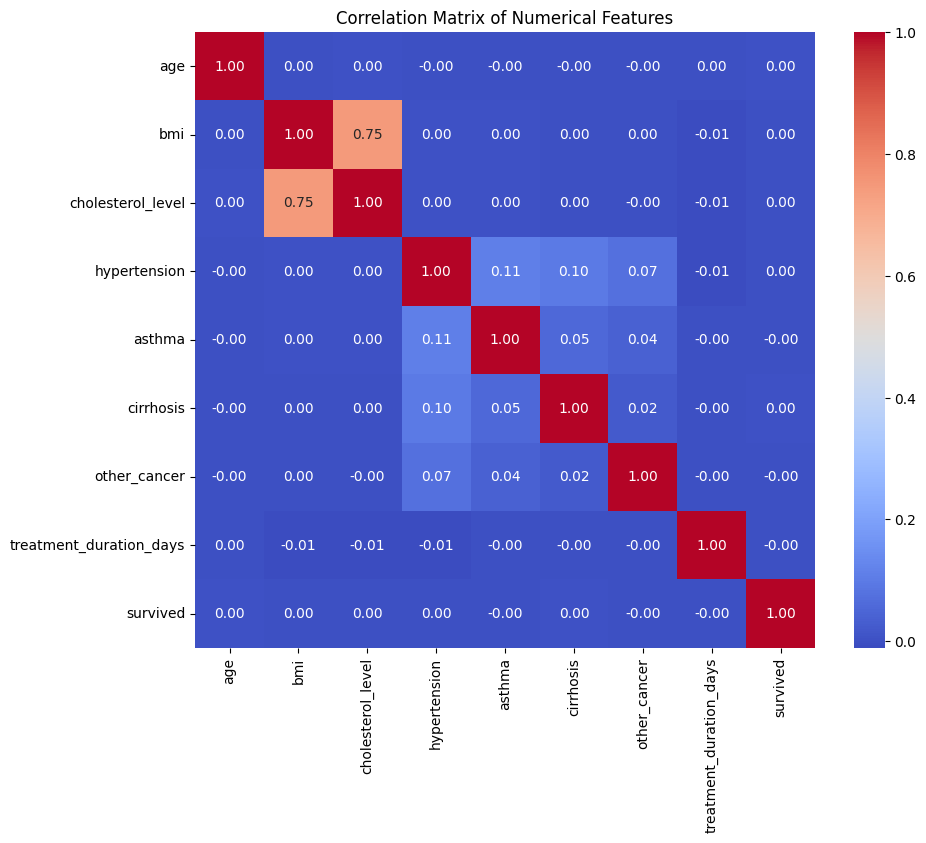

In [19]:
# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols + ['survived']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [20]:
# Load preprocessed data
df_eda = pd.concat([X_train_preprocessed, y_train.reset_index(drop=True)], axis=1)

<Figure size 1200x800 with 0 Axes>

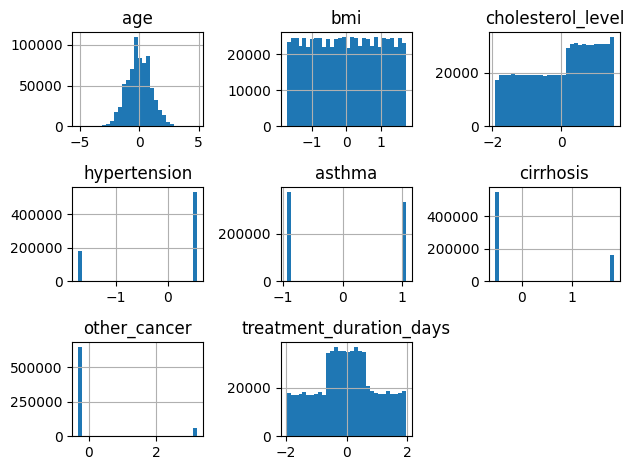

In [21]:
# Plot distribution of numerical features
plt.figure(figsize=(12, 8))
df_eda[numerical_cols].hist(bins=30)
plt.tight_layout()
plt.show()

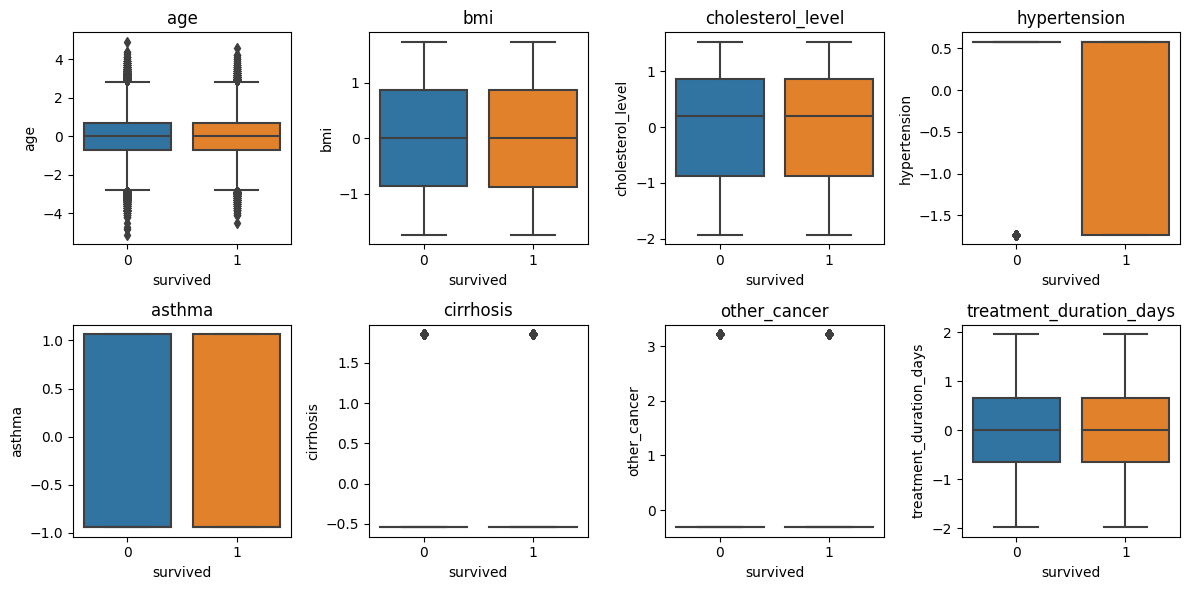

In [22]:
# Plot box plots for numerical features vs. survived
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x='survived', y=col, data=df_eda)
    plt.title(col)
plt.tight_layout()
plt.show()

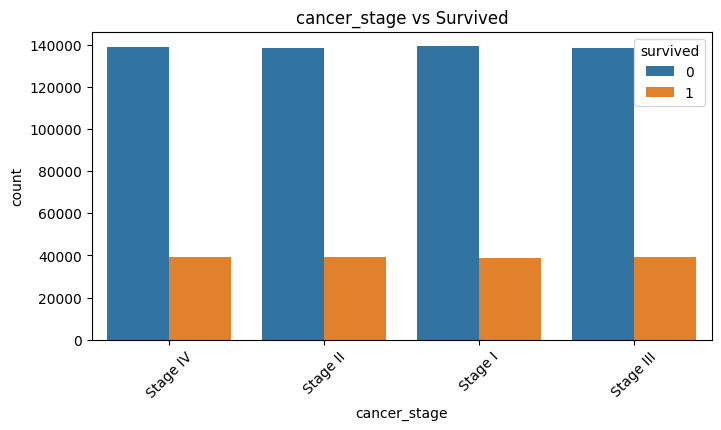

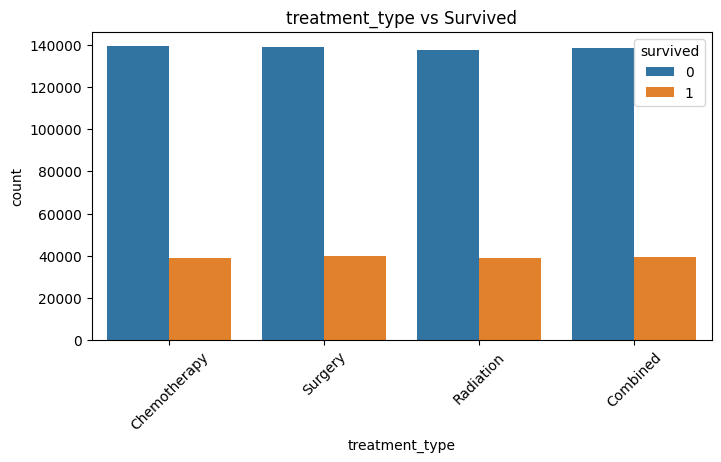

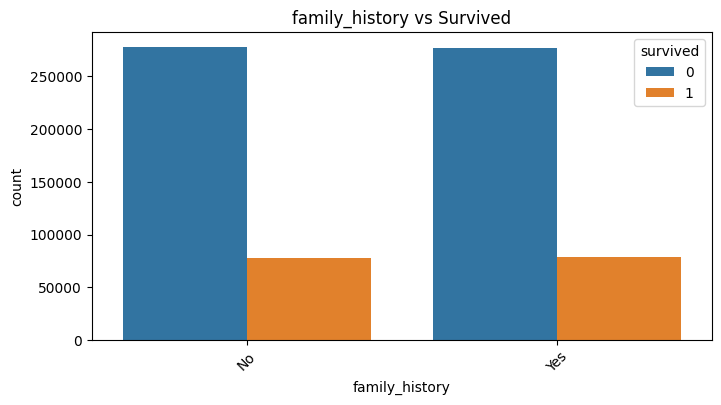

In [23]:
# Plot count plots for key categorical features vs. survived
categorical_cols_reduced = ['cancer_stage', 'treatment_type', 'family_history']  # Subset for clarity
for col in categorical_cols_reduced:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='survived', data=pd.concat([X_train[col], y_train], axis=1))
    plt.title(f'{col} vs Survived')
    plt.xticks(rotation=45)
    plt.show()

#### **Analysis of Results**

**1. Correlation Matrix:**

- Strong positive correlations between comorbidities  (hypertension and asthma: 0.11, asthma and cirrhosis: 0.05). Points to potential multicollinearity that could affect model performance.
- BMI and cholesterol_level show a moderate correlation (0.75).
- Survived shows weak correlations with all numerical features (all < 0.01), suggesting that categorical or engineered features (e.g., treatment_type, cancer_stage) may be more predictive, which we can explore in EDA.
- No strong predictors of survived are evident from numerical features alone

**2. Distribution (Histograms):**

- **age:** Normally distributed, centered around 0 after scaling.
- **bmi and cholesterol_level:** Both show a relatively normal distribution, but cholesterol_level has a slight left skew. This means that there are a few patients with unusually low levels.
- **hypertension, asthma, cirrhosis, other_cancer:** These binary features (scaled) show bimodal distributions, with most values clustering at either -1 or 1.
- **treatment_duration_days:** Slightly right-skewed, with a peak near 0 and a tail extending to positive values. Some negative values persist

**3. Box Plots (Numerical Features vs. Survived):**

- **age, bmi, cholesterol_level, treatment_duration_days:** Medians and interquartile ranges are nearly identical between survived=0 and survived=1, suggets that these features may not be strong direct predictors of survival.
- **hypertension, asthma, cirrhosis, other_cancer:** Slight differences in medians exist (e.g., cirrhosis is slightly higher for survived=0), but the overlap is significant
- No significant outliers are visible likely due to the large dataset.

**4. Categorical Features: Count Plots**

- **Cancer Stage vs. Survived:**
    - Across all stages (I, II, III, IV), the proportion of non-survivors (survived=0) is consistently higher, which is consistent with the class imbalance (77.98% non-survivors).
    - Stage IV has the highest count of patients, followed by Stage II, I, and III. However, the survival ratio appears similar across stages, suggesting cancer_stage may not be a strong predictor of survival in this dataset, which is counterintuitive and may indicate data quality issues or a need for interaction terms (e.g., with treatment_type).
- **Treatment Type vs. Survived:**
    - Chemotherapy has the highest patient count, followed by Surgery, Radiation, and Combined treatments.
    - The survival ratio (orange vs. blue) is slightly higher for Surgery and Combined treatments compared to Chemotherapy and Radiation. This suggests treatment_type may have some predictive power, with Surgery and Combined potentially linked to better outcomes.
- **Family History vs. Survived:**
    - Patients are roughly evenly split between having and not having a family history of cancer.
    - The survival ratio appears nearly identical for both groups, indicating that family_history may not be a strong predictor of survival in this dataset.

**Key Observations**

- The count plots consistently show a higher proportion of non-survivors, aligning with the 77.98% vs. 22.02% split. This reinforces the need for class weighting or resampling techniques during modeling to avoid bias toward the majority class.
- The box plots indicate that numerical features like age, bmi, and cholesterol_level do not strongly differentiate between survival outcomes, consistent with the weak correlations observed earlier.
- treatment_type shows some variation in survival rates, making it a candidate for feature importance analysis. cancer_stage and family_history show less discriminative power than expected, which may require further investigation (e.g., interaction effects or data quality checks).
- The presence of negative treatment_duration_days values needs to be addressed

## Model Selection and Training

In [26]:
# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

In [27]:
# Compute class weights to handle imbalance
class_weights = {0: 1.0, 1: 0.779771 / 0.220229}  

In [28]:
# Initialize models with class weighting
models = {
    'Logistic Regression': LogisticRegression(class_weight=class_weights, random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(class_weight=class_weights, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(scale_pos_weight=0.779771 / 0.220229, random_state=42, eval_metric='logloss', n_jobs=-1)
}

In [29]:
# Perform cross-validation for each model
results = {}
for name, model in models.items():
    cv_results = cross_validate(model, X_train_preprocessed, y_train, cv=5, scoring=scoring, return_train_score=False)
    results[name] = {
        'Accuracy': np.mean(cv_results['test_accuracy']),
        'Precision': np.mean(cv_results['test_precision']),
        'Recall': np.mean(cv_results['test_recall']),
        'F1': np.mean(cv_results['test_f1']),
        'AUC-ROC': np.mean(cv_results['test_roc_auc'])
    }

In [30]:
# Display results
for name, metrics in results.items():
    print(f"\nModel: {name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


Model: Logistic Regression
Accuracy: 0.4944
Precision: 0.2208
Recall: 0.5123
F1: 0.3086
AUC-ROC: 0.5010

Model: Random Forest
Accuracy: 0.7795
Precision: 0.2321
Recall: 0.0006
F1: 0.0011
AUC-ROC: 0.5016

Model: XGBoost
Accuracy: 0.5141
Precision: 0.2204
Recall: 0.4756
F1: 0.3013
AUC-ROC: 0.5007


- All models struggle to predict the minority class (survivors) despite class weighting. Random Forest's near-zero recall indicates it’s heavily biased toward the majority class, while Logistic Regression and XGBoost perform better in recall but at the cost of low precision.
- Logistic Regression and XGBoost outperform Random Forest in terms of recall and F1, making them better at identifying survivors, though their overall performance is still poor. Random Forest’s high accuracy is misleading as it aligns with the majority class proportion.
- All models are struggling to distinguish between classes as shown by the AUC-ROC scores of around 0.5. This suggests the features may not be sufficiently discriminative.